In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

KeyboardInterrupt: 

In [ ]:
#install required bioconductor and github packages
bioc = ro.packages.importr('BiocManager') 
remotes = ro.packages.importr('remotes')
utils = ro.packages.importr('utils')
utils.chooseCRANmirror(ind=1)

bioc.install('scran')
bioc.install('BiocParallel')
bioc.install('scry')

remotes.install_github('carmonalab/STACAS') #for integration based on MNNs
remotes.install_github('carmonalab/ProjecTILs') #for annotating Tcell subtypes
bioc.install('UCell')
utils.install_packages('scGate')#for celltype annotation

In [4]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')
stacas = ro.packages.importr('STACAS')
seurat = ro.packages.importr('Seurat')
scgate = ro.packages.importr('scGate')
Matrix = ro.packages.importr('Matrix')
ProjecTILs = ro.packages.importr('ProjecTILs')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### 1. Import all the data

In [ ]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

### 2. Demultiplex using HTODemux

In [14]:
hto_and_adata_list = [dp.generate_hto_adata_object(adata, rename=True) for adata in adatas]
zipped = list(zip(*hto_and_adata_list))
adata_htos = zipped[0]
adata_nohtos = zipped[1]

In [ ]:
for adata, adata_hto in zip(adata_nohtos, adata_htos):
    #import data
    %R -i adata -i adata_hto
    #convert dgRMatrix to dgCMatrix
    %R assay(adata_hto, 'X') <- as(as.matrix(assay(adata_hto, 'X')), 'dgCMatrix')
    %R assay(adata, 'X') <- as(as.matrix(assay(adata, 'X')), 'dgCMatrix')
    #convert to seurat object
    %R adata_seurat <- CreateSeuratObject(counts = assay(adata, 'X'))
    #create HTO assay
    %R adata_seurat[["HTO"]] <- CreateAssayObject(counts = assay(adata_hto, 'X') + 1) #+1 adds a small pseudocount to avoid clusters with cells containing only 0 counts for a given HTO
    #normalize hto counts
    %R adata_seurat <- NormalizeData(adata_seurat, assay = "HTO", normalization.method = "CLR")
    #Demultiplex using HTODemux
    %R adata_seurat <- HTODemux(adata_seurat, assay = "HTO", positive.quantile = 0.99, kfunc = 'kmeans')
    #define classification and assign cells to it
    %R sample_class <- adata_seurat$HTO_classification
    %R sample_class_global <- adata_seurat$HTO_classification.global
    %R -o sample_class
    %R -o sample_class_global
    adata.obs['specific_class'] = sample_class
    adata.obs['Classification'] = sample_class_global
adatas_singlets = [dp.filter_for_singlets(adata) for adata in adata_nohtos]
sum([adata.shape[0] for adata in adatas_singlets])

### 3. perform quality control

In [26]:
# adatas_mad = dp.quality_control(adatas_singlets)
# adatas_qc = dp.quality_control(adatas_singlets)
# adatas_qc = dp.quality_control(adatas_singlets, method = 'qntl')
adatas_qc = dp.quality_control(adatas_singlets, method = 'abs')
adatas_qc_raw = dp.quality_control(adatas, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9
computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


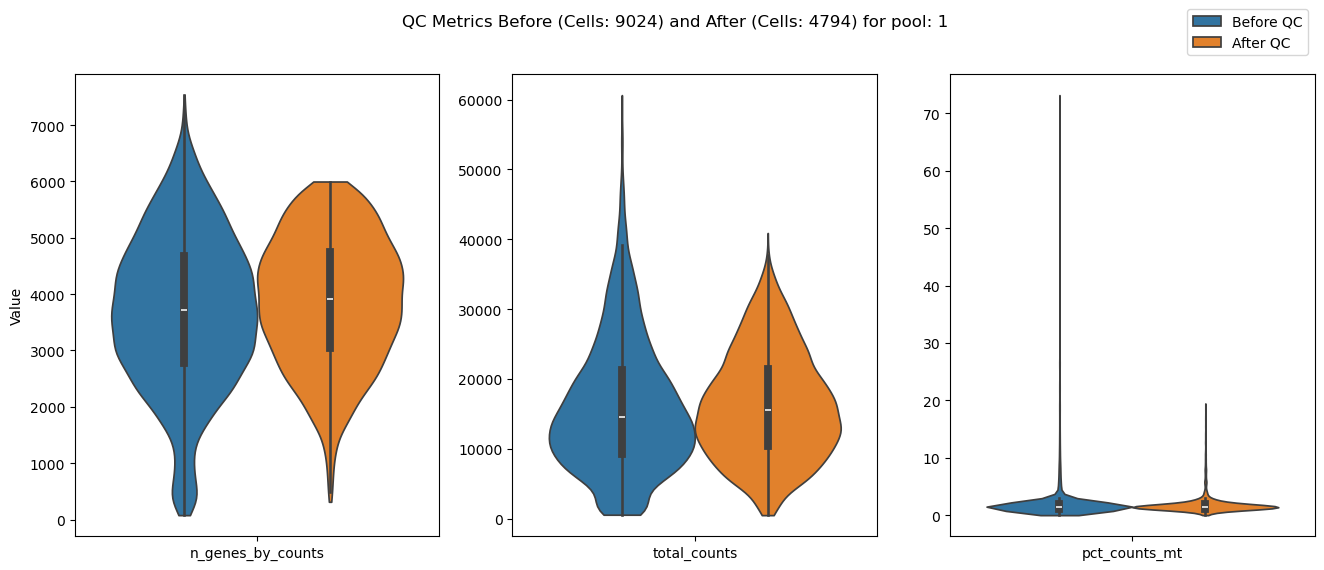

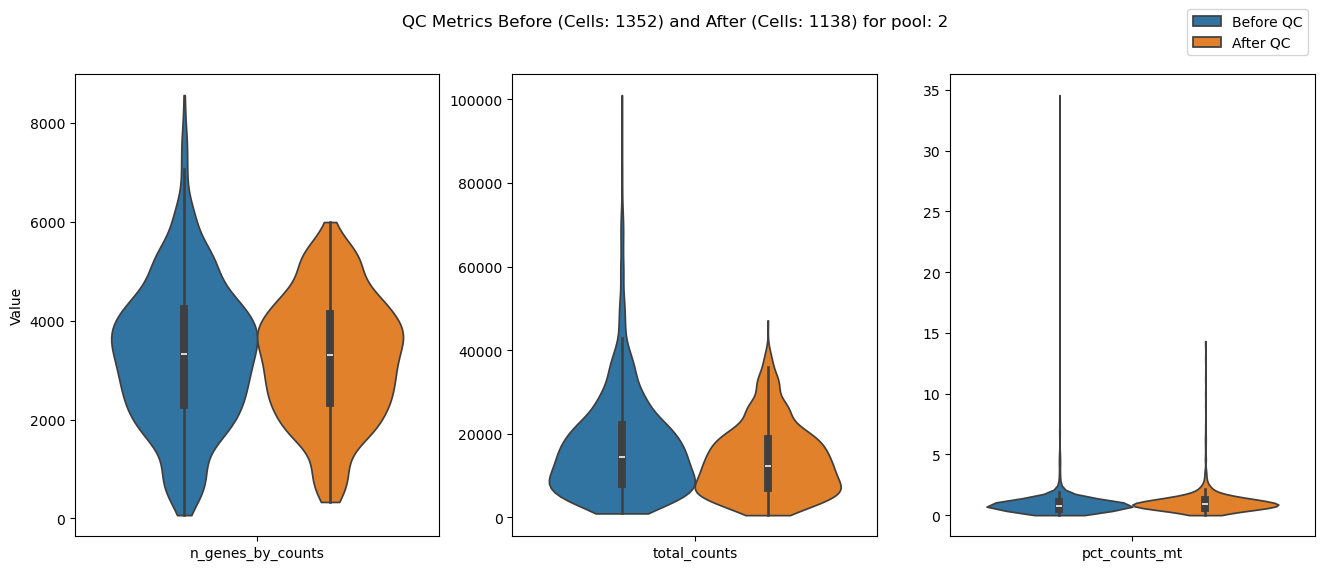

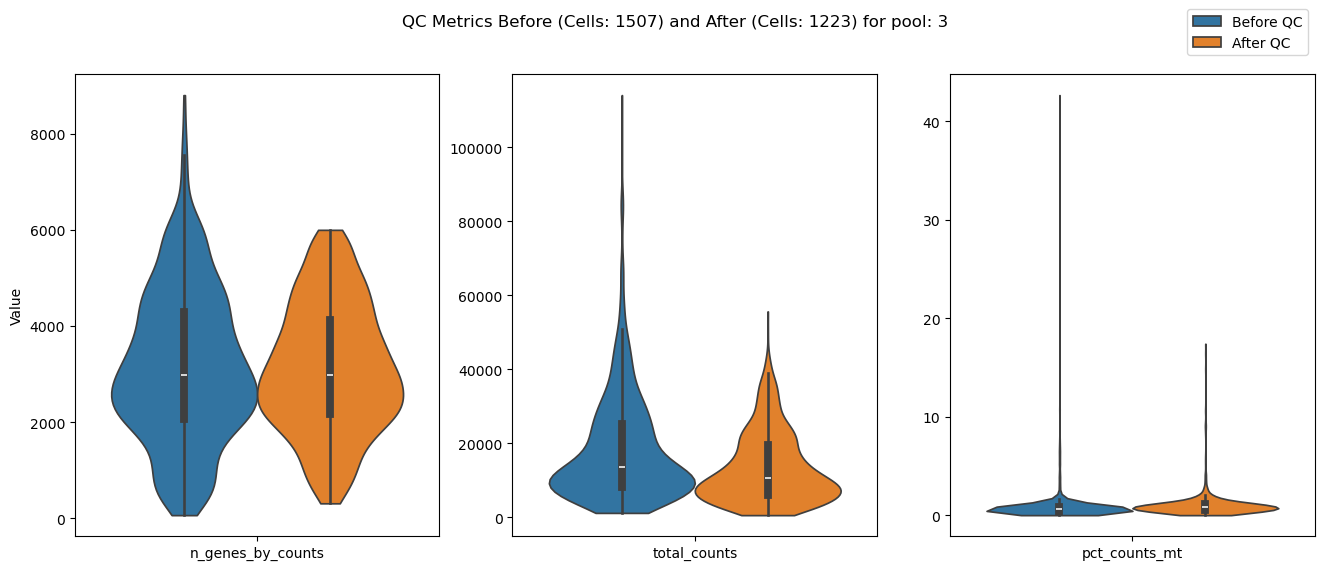

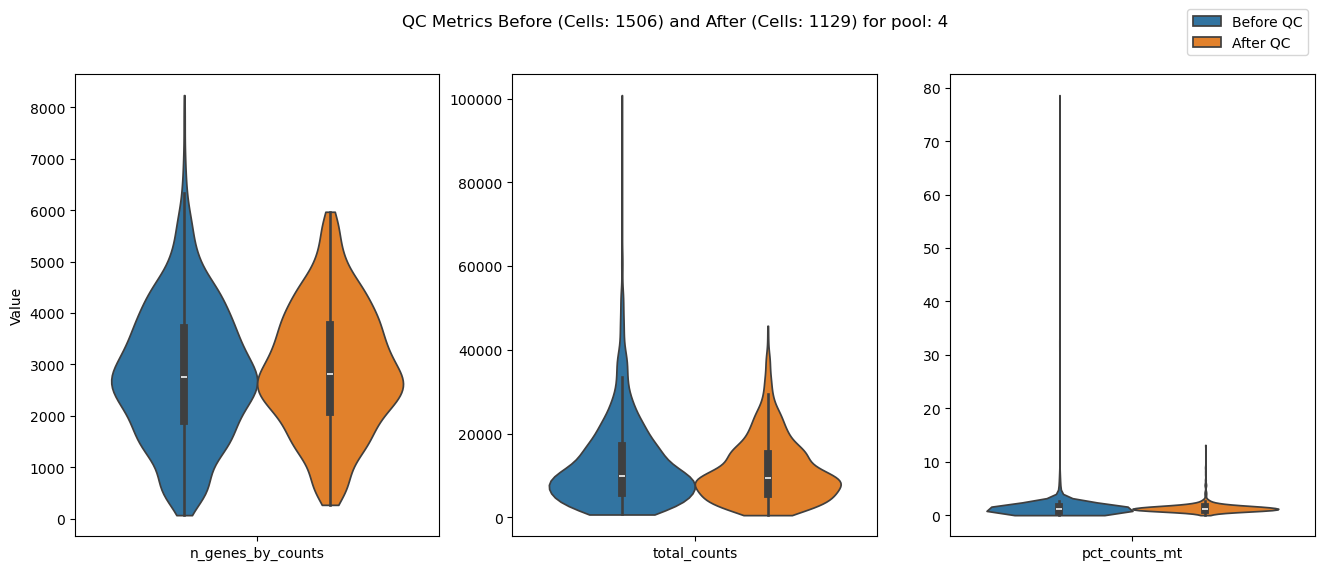

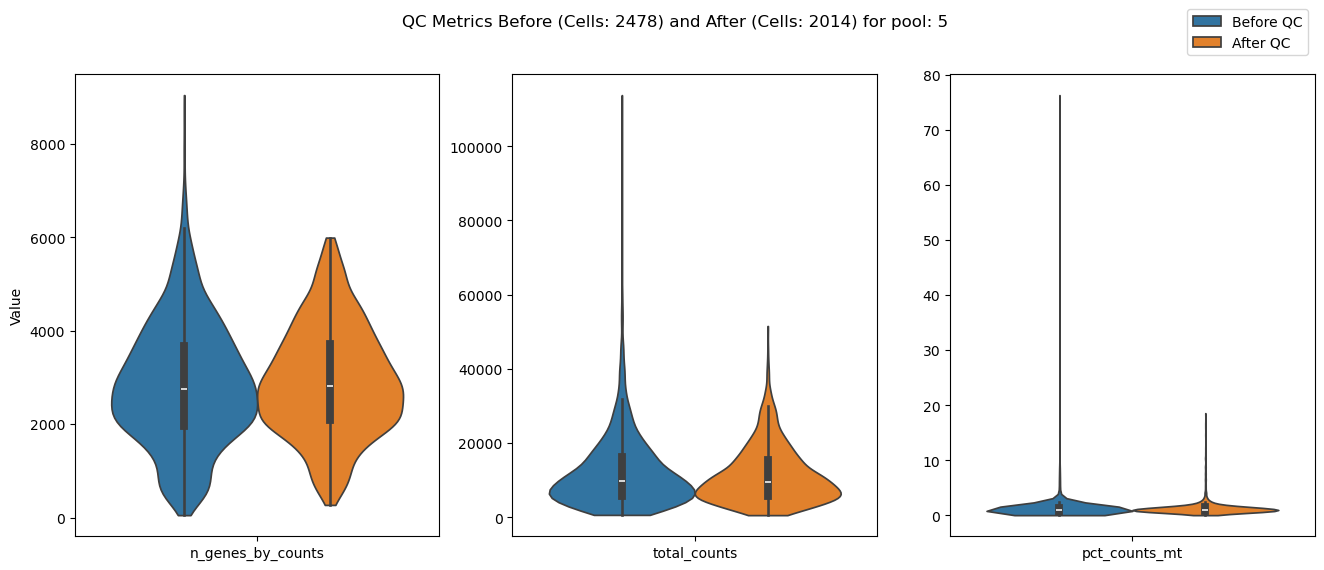

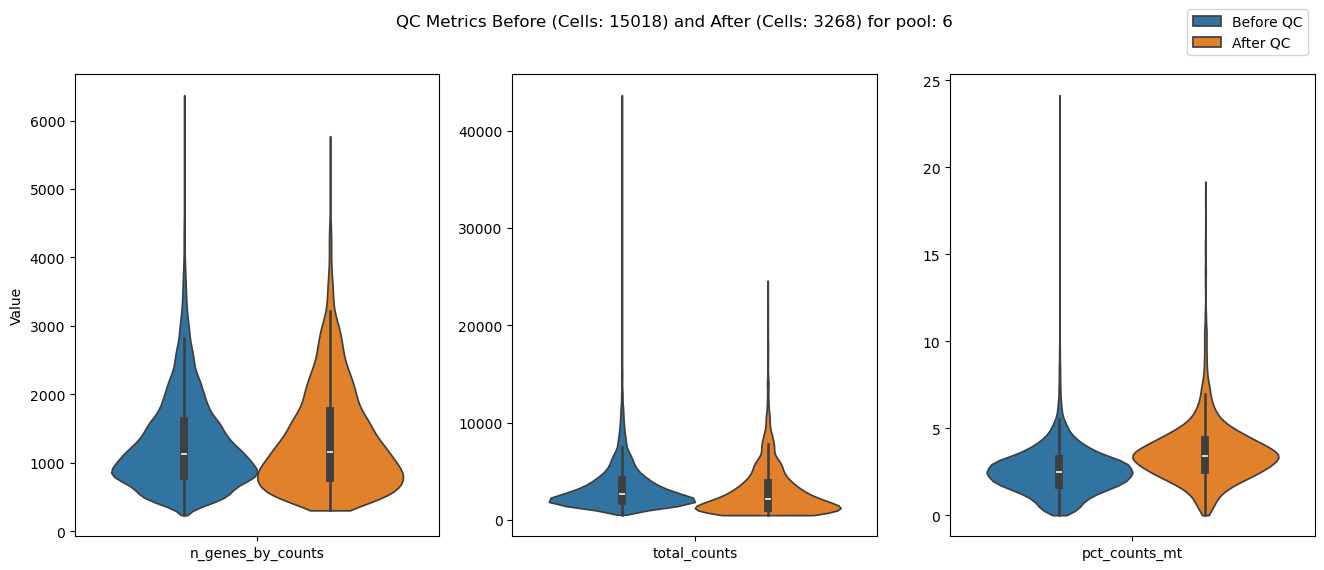

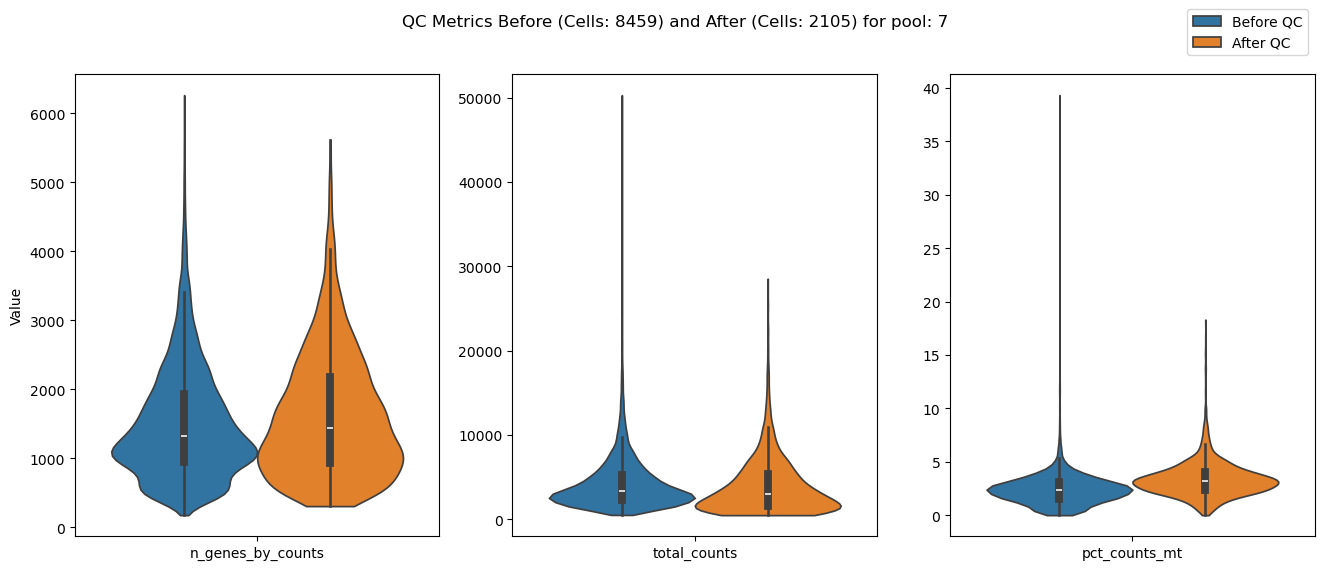

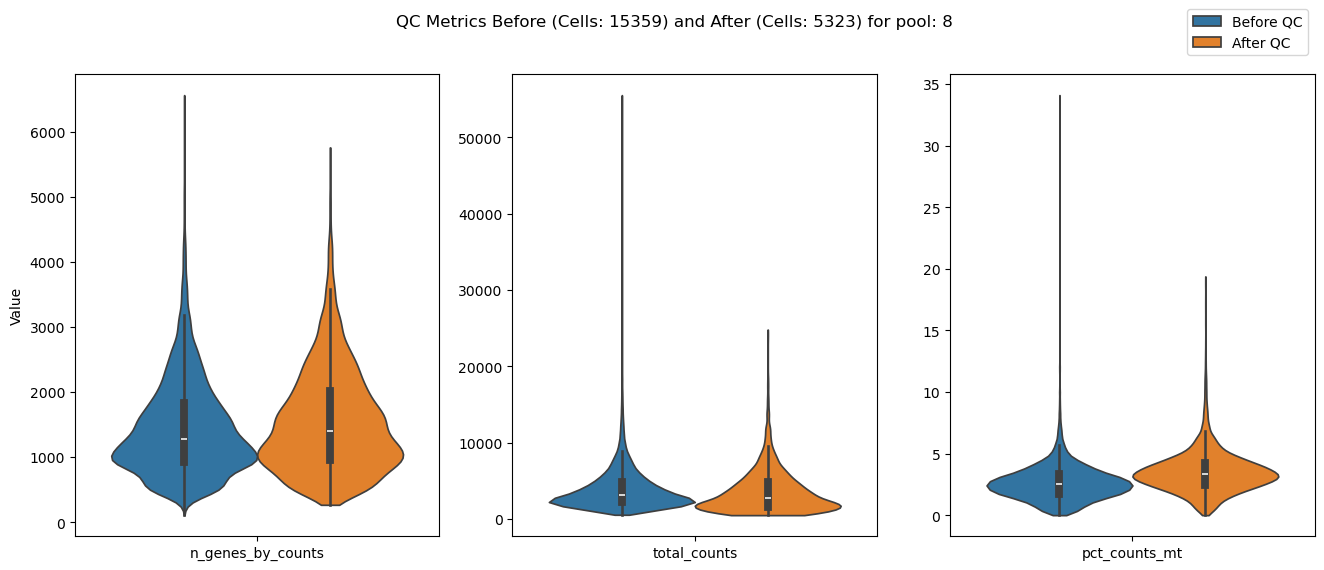

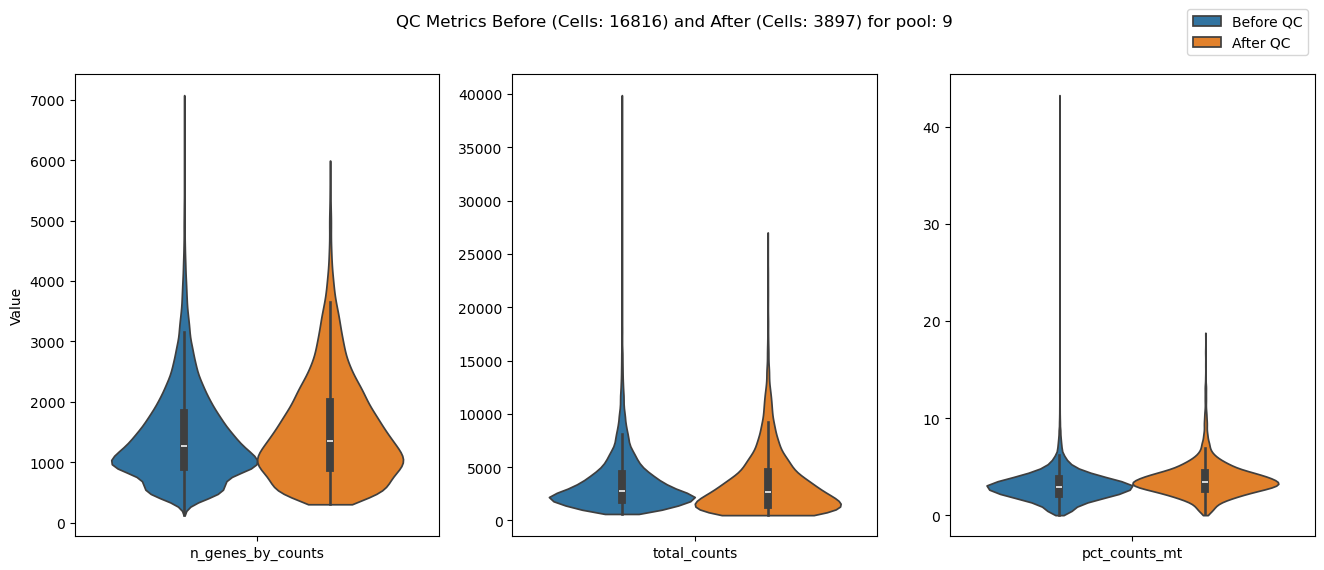

In [27]:
dp.plot_qc_metrics(adatas, adatas_qc)

In [31]:
adatas = adatas_qc

In [32]:
sum([adata.shape[0] for adata in adatas])

24891

### 4. Perform SoupX to correct for ambient mRNA

In [44]:
# adatas_raw = [dp.hashing_columns(adata) for adata in adatas_raw]
groups = [dp.pregroup(adata) for adata in adatas]
adatas = [dp.cook_soup(adata, adata_raw, group) for (adata, adata_raw, group) in zip(adatas, adatas_raw, groups)]

### 5. Concatenate/merge all the pools

In [46]:
#merge andata objects, do not include genes that are not present in all samples (join = 'inner'), set to join = 'outer' if wanting to retain all genes if present in at least one dataset
adata_merged = ad.concat(adatas, join='inner', label='dataset',index_unique='_')

#there are about 200 dLN cells left after using hashsolo with absolute QC, however there are around 6000 left when using HTODemux
adata_merged = adata_merged[ adata_merged.obs['specific_class'].str.contains('d0')| adata_merged.obs['specific_class'].str.contains('TIL')].copy()

### 6. Normalize the data using shifter logarithm or scran normalization

In [48]:
scales_counts = sc.pp.normalize_total(adata_merged, target_sum=1e4, inplace=False)
adata_merged.layers['log1p'] = sc.pp.log1p(scales_counts["X"], copy=True)

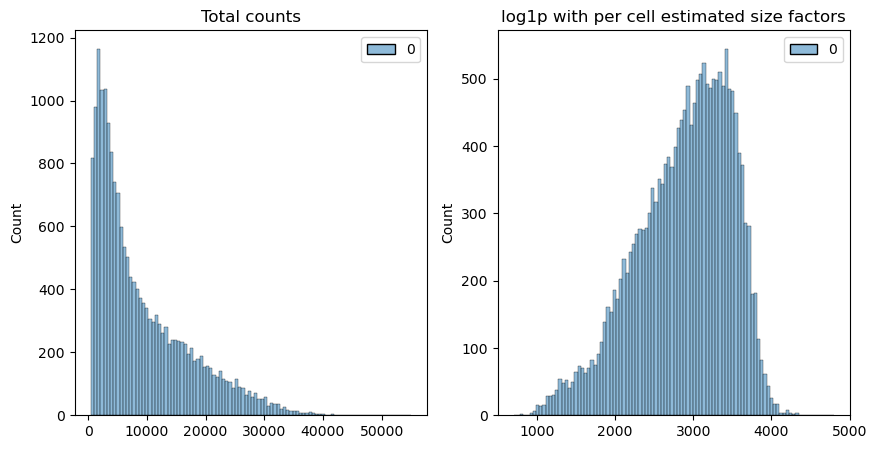

In [49]:
dp.plot_normalization(adata_merged, 'log1p', 'per cell')

In [50]:
#since scran does not really effectively normalize, we use the shifted logarithm
# adata_merged.layers['counts'] = adata_merged.X
adata_merged.X = adata_merged.layers['log1p']

### 7. Perform feature selection

In [52]:
######
#alternatively with seurat, this yields about 60% the same genes, so its slightly different in selecting variale features, however the end result is extremely similar:
######
#first make the concatenated/merged data available to R 
adata_merged_seurat = adata_merged.copy()
adata_merged_seurat.obs['dataset'] = adata_merged_seurat.obs['dataset'].astype(str)
del adata_merged_seurat.uns
ro.globalenv["adata_merged_seurat"] = adata_merged_seurat

#convert from R singleCellObject into a seurat object and split the datasets into a list. Also rename the assay so it will be recognized by all R functions as the original assay
%R seurat <- as.Seurat(adata_merged_seurat, counts = "soupX_counts", data = "log1p") #counts = "soupX_counts" or "counts"
%R seurat <- RenameAssays(seurat, originalexp = "RNA")
%R batch_list <- SplitObject(seurat, split.by = "dataset")

#finally select highly variable genes in a batch aware way in seurat
%R seurat_features <- SelectIntegrationFeatures(batch_list, nfeatures=3000, fvf.nfeatures = 3000)
%R -o seurat_features

#subset the data based on the highly variable genes selected
adata_merged_hvg = adata_merged[:, seurat_features].copy()

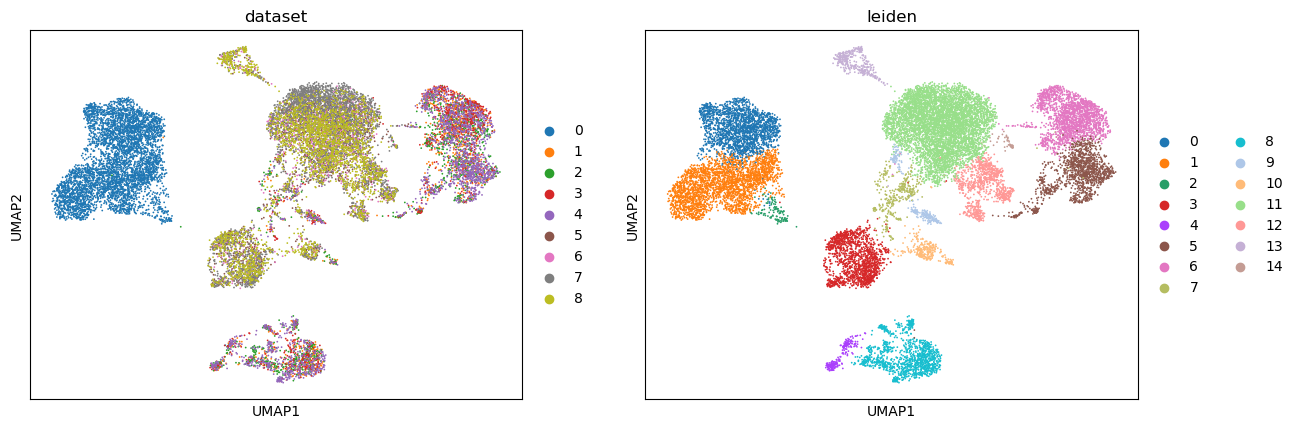

In [53]:
#plot the unintegrated data with coloring the discrete datasets to see their difference
sc.tl.pca(adata_merged_hvg, mask_var=None)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 8. Perform data integration using Mutual Nearest Neighbots (since this is a way to effectively change the count matrix and unlike other integration methods, this yields not only a lower dimensional representation of the data)

In [54]:
#STACAS uses normalized counts, in seurats tutoral, they first do NormalizeData() and use seurat integration afterwards
%R integrated <-  Run.STACAS(batch_list, anchor.features = seurat_features, dims = 1:30) #rownames(seurat) for all features, anchor_features for scanpy version, seurat_features for seurat version

%R integrated_expr <- GetAssayData(integrated)
%R integrated_expr <- t(integrated_expr)
%R -o integrated_expr

adata_merged_hvg.layers['integrated'] = integrated_expr
adata_merged_hvg.X = adata_merged_hvg.layers['integrated']

  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~13s           |++++++++++++                                      | 22% ~06s           |+++++++++++++++++                                 | 33% ~04s           |+++++++++++++++++++++++                           | 44% ~02s           |++++++++++++++++++++++++++++                      | 56% ~02s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~01s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~02m 51s       |+++                                               | 6 % ~02m 43s       |+++++                                             | 8 % ~02

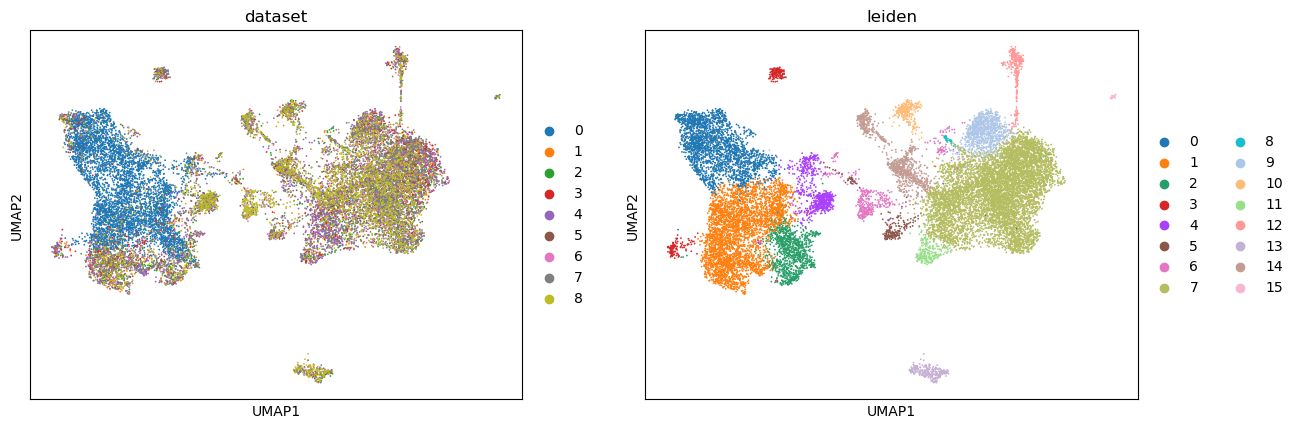

In [55]:
sc.tl.pca(adata_merged_hvg)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 9. Perform Celltype annotation

In [56]:
#using scGate, this is based on the seurat object 'integrated' generated before by stacas. If you are using the integrated matrix from python, you will need to specify the new seurat object and remove reduction = "pca" so that scGate itself generates the pca reduction itself
%R sc_gating_models <- get_scGateDB()
%R seurat_object_annotated <- scGate(integrated, model = sc_gating_models$mouse$generic$Tcell, ncores = 4, reduction = "pca", output.col.name = "is.tcell") #, reduction = 'calculate', assay = 'originalexp'
%R annotation <- seurat_object_annotated@meta.data$is.tcell
%R -o annotation

adata_merged_hvg.obs['is_tcell'] = annotation
sum(adata_merged_hvg.obs.is_tcell == 'Pure')

  |======================================================================| 100%

  |======================================================================| 100%



7548

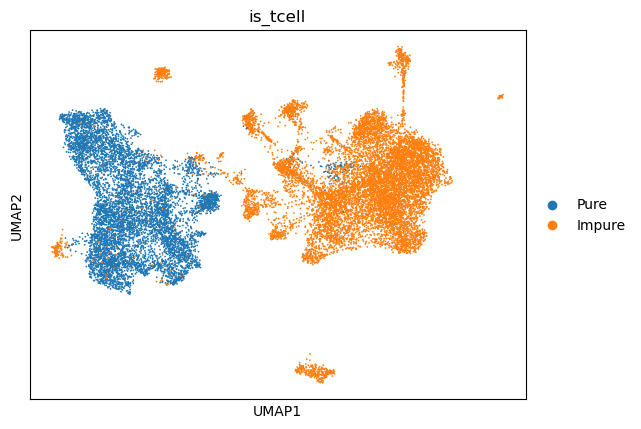

In [57]:
sc.pl.umap(adata_merged_hvg, color='is_tcell')

In [ ]:
#download the reference datasets to map to
%R download.file("https://figshare.com/ndownloader/files/41414556", destfile = "01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R download.file("https://figshare.com/ndownloader/files/39012395", destfile = "01_data/reference_datasets_project_TILs/CD4T_human_ref_v1.rds")

'value'

In [59]:
%R ref.CD8 <- load.reference.map("01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R ref.CD4 <- load.reference.map("01_data/reference_datasets_project_TILs/CD4T_human_ref_v1.rds")
%R DefaultAssay(ref.CD8) <- "integrated"
%R DefaultAssay(ref.CD4) <- "integrated"

[1] "Loading Custom Reference Atlas..."


[1] "Loaded Custom Reference map Human CD8 TILs"
[1] "Loading Custom Reference Atlas..."
[1] "Loaded Custom Reference map custom_reference"


'value'

In [60]:
adata_pure = adata_merged_hvg[adata_merged_hvg.obs['is_tcell'] == 'Pure']

%R ncores <- 8
%R pure_cells <- subset(seurat_object_annotated, subset = is.tcell == "Pure")
%R DefaultAssay(pure_cells) <- "RNA"
%R pure_cells_CD8 <- ProjecTILs.classifier(query = pure_cells, ref = ref.CD8, ncores = ncores) # , split.by = "dataset" filter.cells = FALSE, skip.normalize=TRUE,
%R pure_cells_CD8_CD4 <- ProjecTILs.classifier(query = pure_cells_CD8, ref = ref.CD4, ncores = ncores, overwrite=FALSE) # , overwrite=FALSE
%R TC_annotations <- pure_cells_CD8_CD4@meta.data$functional.cluster
%R -o TC_annotations 

adata_pure.obs['Tcell_subtype'] = TC_annotations
%R print(table(pure_cells_CD8_CD4$functional.cluster, useNA = "ifany"))

  |                                                                      |   0%[1] "Using assay RNA for query"
[1] "3064 out of 7548 ( 41% ) non-pure cells removed. Use filter.cells=FALSE to avoid pre-filtering"
[1] "Transforming expression matrix into space of orthologs"
[1] "Aligning query to reference map for batch-correction..."
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~08s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=10s  
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=19s  

Projecting corrected query onto Reference PCA space

Projecting corrected query onto Reference UMAP space
  |======================================================================| 100%

  |                                                                      |   0%[1] "Using assay RNA for query"
[1

/tmp/ipykernel_3256796/511010560.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pure.obs['Tcell_subtype'] = TC_annotations



CD4.CTL_EOMES   CD4.CTL_Exh  CD4.CTL_GNLY CD4.NaiveLike       CD4.Tfh 
            6            53             5           156           204 
     CD4.Th17      CD4.Treg        CD8.CM        CD8.EM CD8.NaiveLike 
          343           205           426           412            30 
      CD8.TEX      CD8.TPEX          <NA> 
         1318          2298          2092 


'value'

In [61]:
pure_cells = sum(adata_merged_hvg.obs['is_tcell'] == 'Pure')
not_annotated_cells = sum(pd.isnull(adata_pure.obs.Tcell_subtype))
diff = pure_cells - not_annotated_cells
print(f'Pure Cells: {pure_cells}')
print(f'From which {not_annotated_cells} could not be annotated')
print(f'{diff} were annotated')

Pure Cells: 7548
From which 2092 could not be annotated
5456 were annotated


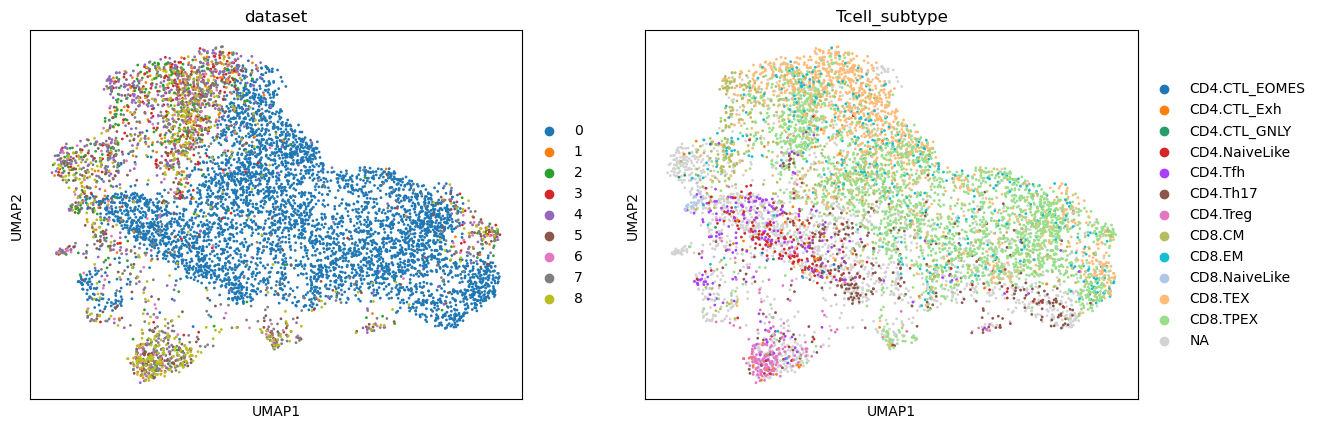

In [62]:
sc.tl.pca(adata_pure)
sc.pp.neighbors(adata_pure)
sc.tl.umap(adata_pure)
sc.tl.leiden(adata_pure, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_pure, color=['dataset', 'Tcell_subtype'])

### 11. Save the progress

In [64]:
adata_pure.write('01_data/processed/merged_and_processed/HTODemux_abs_soupx.h5ad', compression='gzip') #takes forever 